In [1]:
import os
os.chdir('/home/shimingwang/workspace/sf_tv/sceneflow_tv_seflow_codebase')

import os.path as osp
import numpy as np
import h5py, pickle
from collections import defaultdict
from typing import Final
from pathlib import Path

from av2.structures.sweep import Sweep
from av2.datasets.sensor.av2_sensor_dataloader import convert_pose_dataframe_to_SE3
from av2.map.map_api import ArgoverseStaticMap
from av2.structures.cuboid import CuboidList, Cuboid
from av2.utils.io import read_feather

import matplotlib.pyplot as plt



## Define Paths

In [2]:
train_data_root= 'data/Argoverse2_demo/preprocess_v2/sensor/train'
scene_id = '8de6abb6-6589-3da7-8e21-6ecc80004a36'
index_file_name = 'index_total.pkl'

In [8]:
train_data_path  = osp.join(train_data_root, f'{scene_id}.h5')
index_file_path = osp.join(train_data_root, index_file_name)

with open(index_file_path, 'rb') as f:
    index = pickle.load(f)
print(len(index))
print(index)

idx = 68
_, timestamp = index[idx]
print('scene id:', scene_id)
print('timestamp:', timestamp)
print(idx/len(index))

156
[['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974381360403000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974381459935000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974381560132000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974381660328000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974381759861000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974381860057000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974381960253000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974382060433000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974382159966000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974382260162000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974382360358000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974382459891000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974382560087000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974382660284000'], ['8de6abb6-6589-3da7-8e21-6ecc80004a36', '315974382759817000'], ['8de6abb6-6589-3da7-8e21-6ecc80004

### Check number of points

In [16]:
num_raw_pts_list = []
num_pts_wo_ground_list = []

with h5py.File(train_data_path, 'r') as f:
    for idx in range(len(index)):
        _, timestamp = index[idx]
        data = f[timestamp]
        num_raw_pts_list.append(data['lidar'].shape[0])
        num_pts_wo_ground_list.append(np.sum(~np.array(data['ground_mask'])))

In [18]:
print(len(num_raw_pts_list))
print(np.mean(num_raw_pts_list))

print(len(num_pts_wo_ground_list))
print(np.mean(num_pts_wo_ground_list))

156
95596.33333333333
156
80214.90384615384


## check the h5 file

In [4]:
vis_data = dict()

with h5py.File(train_data_path, 'r') as f:
    print(f.keys())
    data = f[timestamp]
    print(data.keys())
    print(data['label'].shape)
    print(data['dufo_label'].shape)
    
    vis_data['pc0'] = np.array(data['lidar'][:, :3])
    vis_data['hdbscan_label'] = np.array(data['label'])
    vis_data['gt_label'] = np.array(data['flow_category_indices'])
    vis_data['dufo_label'] = np.array(data['dufo_label'])
    vis_data['gm'] = np.array(data['ground_mask'])
    
    print('HDBSCAN clustering label:', np.unique(data['label']))
    print('dufo lable:', np.unique(data['dufo_label']))
    print('lidar:', data['lidar'].shape, np.unique(data['lidar']))
    print('flow category indices:', data['flow_category_indices'].shape, np.unique(data['flow_category_indices']))
    print('ground mask:', data['ground_mask'].shape, np.unique(data['ground_mask']))

<KeysViewHDF5 ['315974381360403000', '315974381459935000', '315974381560132000', '315974381660328000', '315974381759861000', '315974381860057000', '315974381960253000', '315974382060433000', '315974382159966000', '315974382260162000', '315974382360358000', '315974382459891000', '315974382560087000', '315974382660284000', '315974382759817000', '315974382860013000', '315974382960209000', '315974383059725000', '315974383159921000', '315974383260118000', '315974383359650000', '315974383459847000', '315974383560043000', '315974383659576000', '315974383759772000', '315974383859969000', '315974383960165000', '315974384060345000', '315974384163365000', '315974384260074000', '315974384360271000', '315974384460467000', '315974384560000000', '315974384660196000', '315974384759729000', '315974384859925000', '315974384960122000', '315974385059639000', '315974385159835000', '315974385260031000', '315974385359564000', '315974385459760000', '315974385559957000', '315974385660153000', '3159743857596860

In [5]:
def pc_vis(pc,
           c = None,
           size = 1,
           range = (-54, 54), 
           title = None
           ):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(pc[:,0], 
               pc[:,1],
               c = c,
               sizes=np.ones_like(pc[:,0])*size,)
    ax.set_xlim(*range)
    ax.set_ylim(*range)   
    ax.set_alpha(0.5) 
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)
    plt.show()

(82416, 3)


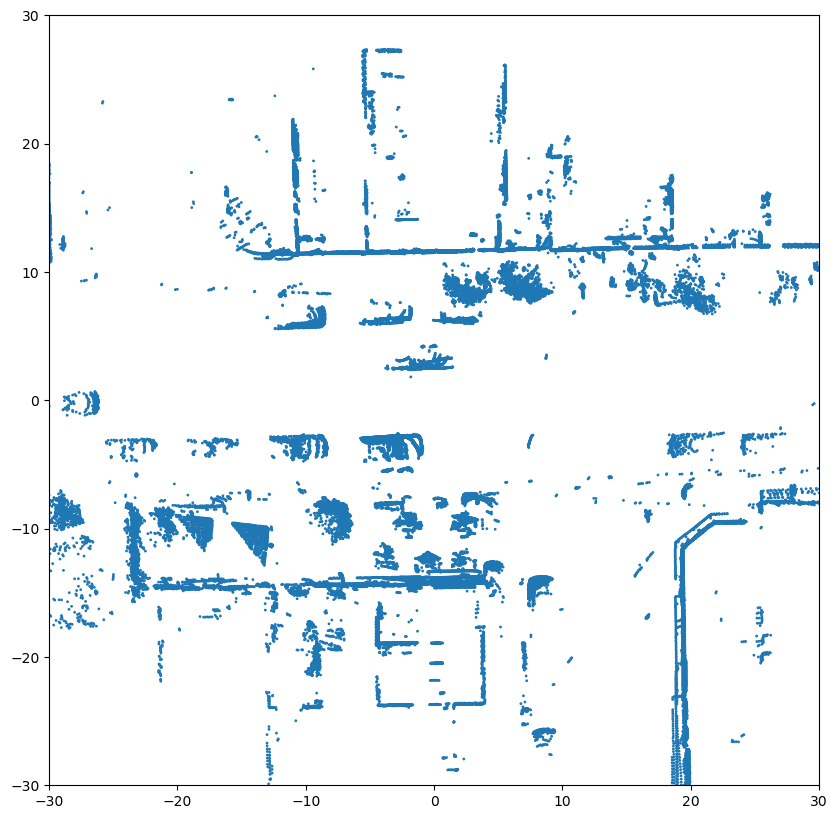

In [6]:
pc0 = vis_data['pc0'][~vis_data['gm']]
print(pc0.shape)
pc_vis(pc0, size=1, range=(-30, 30))

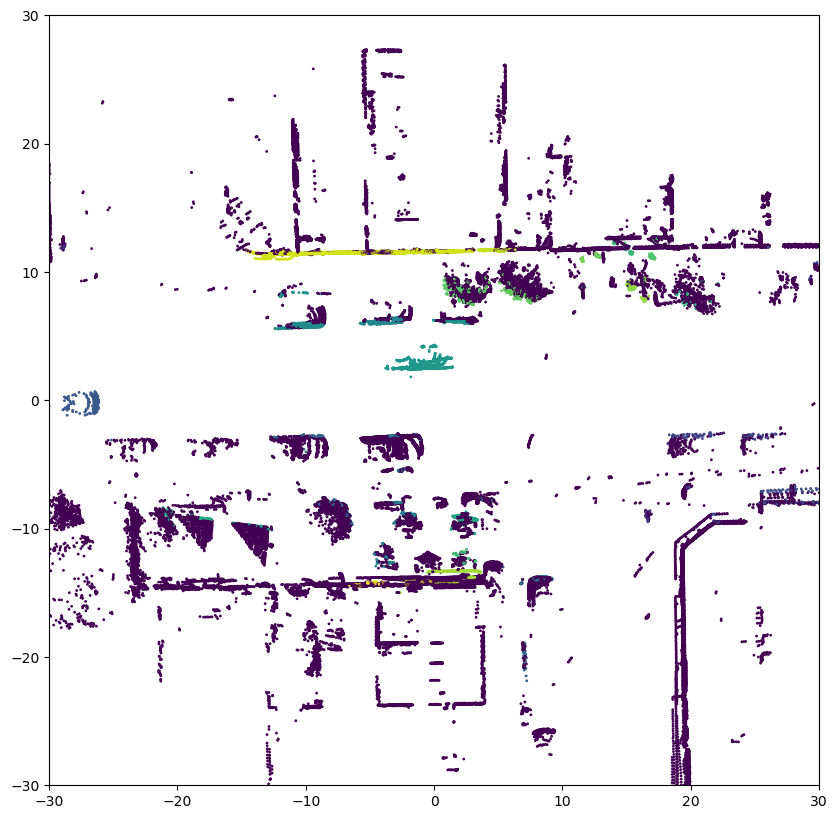

In [28]:
pc0 = vis_data['pc0'][~vis_data['gm']]
cluster_label = vis_data['hdbscan_label'][~vis_data['gm']]
pc_vis(pc0, c = cluster_label, size=1, range=(-30, 30))

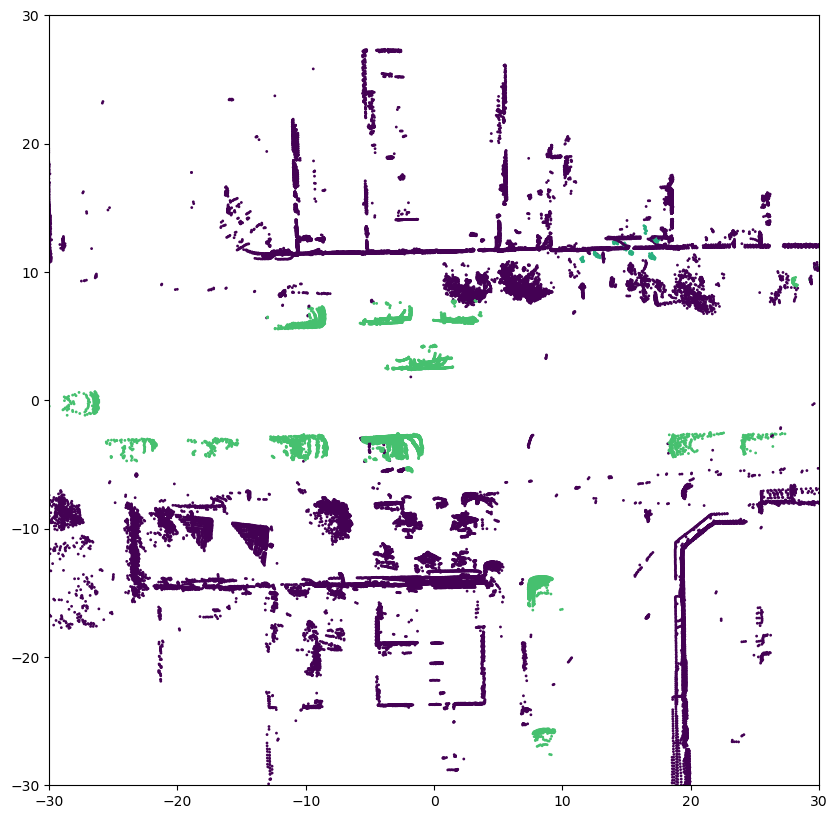

In [29]:
pc0 = vis_data['pc0'][~vis_data['gm']]
gt_label = vis_data['gt_label'][~vis_data['gm']]

pc_vis(pc0, c = gt_label, size=1, range=(-30, 30))

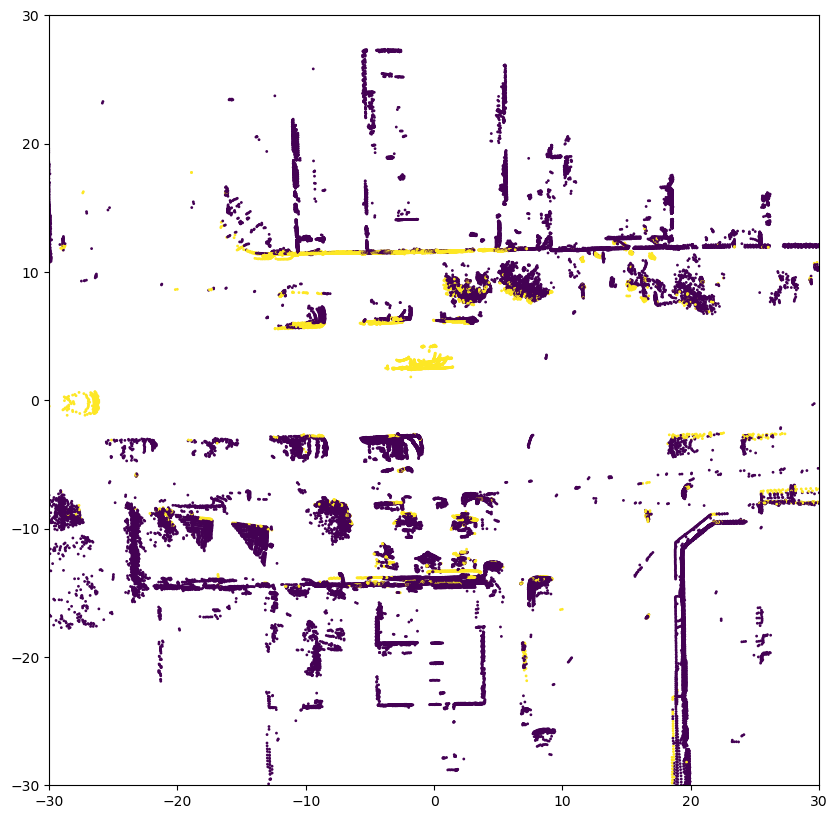

In [30]:
pc0 = vis_data['pc0'][~vis_data['gm']]
dufo_label = vis_data['dufo_label'][~vis_data['gm']]
pc_vis(pc0, c = dufo_label, size=1, range=(-30, 30))

## Get bounding box for the scene id

In [10]:
data_root =  'data/Argoverse2'
av2_type = 'sensor'
data_mode = 'train'

data_path = osp.join(data_root, av2_type, data_mode)
print(data_path)

data/Argoverse2/sensor/train


In [11]:
annotation_feather_path = osp.join(data_path, scene_id, 'annotations.feather')
cuboid_list = CuboidList.from_feather(annotation_feather_path)

In [12]:
print(type(cuboid_list))
print(len(cuboid_list))
# 315974381360403000
print(cuboid_list[0])

cuboid_timestamp_list = set([cuboid.timestamp_ns for cuboid in cuboid_list])
print(len(cuboid_timestamp_list)) 

<class 'av2.structures.cuboid.CuboidList'>
9874
Cuboid(dst_SE3_object=SE3(rotation=array([[-0.94440461, -0.32878554,  0.        ],
       [ 0.32878554, -0.94440461,  0.        ],
       [ 0.        ,  0.        ,  1.        ]]), translation=array([16.32065551,  8.84896104, -0.23489335])), length_m=1.5, width_m=0.5, height_m=1.0, timestamp_ns=315974381360403000, category='BICYCLE')
156


### Loading annotatiion raw data

In [13]:
raw_ann_data = read_feather(annotation_feather_path)

In [14]:
print(type(raw_ann_data))
print('raw ann data columns:', raw_ann_data.columns)
print('raw ann data shape', raw_ann_data.shape)

ids = raw_ann_data['track_uuid'].to_numpy()
print('track uuid shape', ids.shape)
set_track_uuid = set(ids)

print('track_uuid set:', len(set_track_uuid))

timestamp_cuboid_index = defaultdict(dict)
print(timestamp_cuboid_index)
for id, cuboid in zip(ids, cuboid_list.cuboids):
    timestamp_cuboid_index[cuboid.timestamp_ns][id] = cuboid
print(type(timestamp_cuboid_index))
print(timestamp_cuboid_index.keys(), len(timestamp_cuboid_index.keys()))

for ts in timestamp_cuboid_index.keys():
    if timestamp == ts:
        print('XX timestamp:', ts)
        
tt = list(timestamp_cuboid_index.keys())[idx]
print(tt)
print(timestamp)
print(type(tt))
print(type(timestamp))

<class 'pandas.core.frame.DataFrame'>
raw ann data columns: Index(['timestamp_ns', 'track_uuid', 'category', 'length_m', 'width_m',
       'height_m', 'qw', 'qx', 'qy', 'qz', 'tx_m', 'ty_m', 'tz_m',
       'num_interior_pts'],
      dtype='object')
raw ann data shape (9874, 14)
track uuid shape (9874,)
track_uuid set: 129
defaultdict(<class 'dict'>, {})
<class 'collections.defaultdict'>
dict_keys([315974381360403000, 315974381459935000, 315974381560132000, 315974381660328000, 315974381759861000, 315974381860057000, 315974381960253000, 315974382060433000, 315974382159966000, 315974382260162000, 315974382360358000, 315974382459891000, 315974382560087000, 315974382660284000, 315974382759817000, 315974382860013000, 315974382960209000, 315974383059725000, 315974383159921000, 315974383260118000, 315974383359650000, 315974383459847000, 315974383560043000, 315974383659576000, 315974383759772000, 315974383859969000, 315974383960165000, 315974384060345000, 315974384163365000, 315974384260074000,

### Get bounding box for the timestamp

In [15]:
print(timestamp)
print(type(timestamp))

cuboids = timestamp_cuboid_index[int(timestamp)]

print(cuboids.keys())
print(len(cuboids.keys()))

315974393359879000
<class 'str'>
dict_keys(['cff62cb5-ac46-4288-9fe3-ad220d5bb7c1', '3f880930-686f-4f81-b415-7e586f162af9', 'b46c9f1a-8ebe-4d40-b5e1-f8dffaf00213', '016bc5c7-2a5d-456a-bac1-b9268c85ed69', '0f331efd-ec72-4fb1-8a69-fe125d417c50', '11e5fe82-3ecc-4017-8c79-00527f3ecc75', '5ba9c1fd-249c-4694-a631-9809098d1e67', '5fec4cc6-4f77-44d4-beff-1499601450d3', 'a30358a7-d6a1-45d1-8c75-88150dec5c69', 'a5d9b325-82c7-466f-8494-f23ad89957ae', 'e0119562-05fd-4b3c-9816-8ebc29663bbb', '00ff60ee-664d-4350-a2a8-8bffef7ac186', '0f0f6c8e-5c8f-4c1f-9554-7111282be2ed', '11906a1f-1f91-4e68-aad7-806ab1db28a9', '143441d6-37d1-42ef-8ffd-5899d255a47b', '1d6484f5-46ab-4b42-9174-bbd863d1b290', '24154188-cb82-4087-abed-7c3e7c370cee', '2533df15-db02-4e74-9b27-c9941a5c505c', '2665bc9a-dec0-4641-8199-ffa64e95b72e', '2bb79a02-bc3b-45ad-86f9-2e2cb1130da4', '3629c321-85e8-4559-b1fc-1386c648fd9d', '3742f1d7-a839-491a-8b5d-b6976ce65e4e', '3ad0e1df-1a28-4b85-8d04-587ca5d278e2', '506510f4-de93-4097-8409-8b474347f73

### Get ego vehicle position

In [16]:
log_poses_df = read_feather(osp.join(data_path, scene_id, 'city_SE3_egovehicle.feather'))
print(type(log_poses_df))
print(log_poses_df.columns) 
print(log_poses_df.head())
print(log_poses_df.shape)

<class 'pandas.core.frame.DataFrame'>
Index(['timestamp_ns', 'qw', 'qx', 'qy', 'qz', 'tx_m', 'ty_m', 'tz_m'], dtype='object')
         timestamp_ns        qw        qx        qy        qz        tx_m  \
0  315974381307428273  0.720074  0.011332 -0.012825 -0.693686 -269.067392   
1  315974381312451240  0.720083  0.011298 -0.012838 -0.693677 -269.066111   
2  315974381322412932  0.720121  0.011211 -0.012962 -0.693637 -269.063881   
3  315974381327482487  0.720134  0.011199 -0.012989 -0.693623 -269.062485   
4  315974381337425431  0.720152  0.011220 -0.012947 -0.693604 -269.059497   

          ty_m       tz_m  
0  2821.504106 -21.682772  
1  2821.467513 -21.682789  
2  2821.400126 -21.680221  
3  2821.363173 -21.680221  
4  2821.284435 -21.683380  
(2698, 8)


In [17]:
## get the ego pose at the timestamp

filtered_log_poses_df = log_poses_df[log_poses_df['timestamp_ns'] == int(timestamp)]
print(filtered_log_poses_df.shape)
print(filtered_log_poses_df)

(1, 8)
            timestamp_ns        qw        qx        qy        qz        tx_m  \
2039  315974393359879000  0.724322  0.012068 -0.014924 -0.689195 -266.135199   

             ty_m      tz_m  
2039  2748.533743 -21.32639  


In [18]:
## convert pose to SE3
pose = convert_pose_dataframe_to_SE3(filtered_log_poses_df)
print(pose)

SE3(rotation=array([[ 0.04957601,  0.9980375 , -0.03825396],
       [-0.99875791,  0.04973019,  0.0030888 ],
       [ 0.00498511,  0.03805331,  0.99926328]]), translation=array([-266.13519883, 2748.53374258,  -21.32638969]))


### Get internal points within a bounding box

In [19]:
BOUNDING_BOX_EXPANSION: Final = 0.2
for id in cuboids:
    c0 = cuboids[id]
    print('c0:', c0)
    c0.length_m += BOUNDING_BOX_EXPANSION
    c0.width_m += BOUNDING_BOX_EXPANSION
    obj_pts, obj_mask = c0.compute_interior_points(vis_data['pc0'])
    
    print('pc0 shape:', pc0.shape)
    print('obj_pts shape:', obj_pts.shape, obj_pts)
    print('obj_mask shape:', obj_mask.shape)
    break

c0: Cuboid(dst_SE3_object=SE3(rotation=array([[-9.99999998e-01, -6.20693924e-05,  0.00000000e+00],
       [ 6.20693924e-05, -9.99999998e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]), translation=array([-1.09197905e+02,  1.12756432e+01,  5.33798634e-02])), length_m=1.0433005094528198, width_m=0.6559674739837646, height_m=1.6782093048095703, timestamp_ns=315974393359879000, category='BICYCLIST')
pc0 shape: (82856, 3)
obj_pts shape: (0, 3) []
obj_mask shape: (96926,)


### Reload point cloud


In [20]:
### load data from av2
from dataprocess.extract_av2 import read_pose_pc_ground


data_path_ab = '/home/shimingwang/workspace/sf_tv/sceneflow_tv_seflow_codebase/data/Argoverse2/sensor/train'
log_map_dirpath = Path(data_path_ab) / scene_id /'map'

print(log_map_dirpath)

avm = ArgoverseStaticMap.from_map_dir(log_map_dirpath, build_raster=True)
pc0_raw, pose0, is_ground_0 = read_pose_pc_ground(Path(data_path), scene_id, int(timestamp), avm)

print('pc0_raw:', pc0_raw.shape)
print('pose0:', pose0)
print('is_ground_0:', is_ground_0.shape)

/home/shimingwang/workspace/sf_tv/sceneflow_tv_seflow_codebase/data/Argoverse2/sensor/train/8de6abb6-6589-3da7-8e21-6ecc80004a36/map
pc0_raw: (96926, 3)
pose0: SE3(rotation=array([[ 0.04957601,  0.9980375 , -0.03825396],
       [-0.99875791,  0.04973019,  0.0030888 ],
       [ 0.00498511,  0.03805331,  0.99926328]]), translation=array([-266.13519883, 2748.53374258,  -21.32638969]))
is_ground_0: (96926,)


In [21]:
print(vis_data['pc0'][:10,:])
print(pc0_raw[:10,:])   
np.isclose(vis_data['pc0'], pc0_raw).all()

## pc0 is defined in the sensor coordinate
## raw pc0 is defined in the ego coordinate

[[-17.807566    15.26688      0.2736425 ]
 [-14.678301    12.594686    -1.1262598 ]
 [-17.823538    15.313638    -0.8205958 ]
 [-17.80826     15.360627    -0.2732325 ]
 [ -4.8599453    4.198472    -0.5994044 ]
 [-17.792694    15.368556     0.2736425 ]
 [-14.647515    12.657416    -1.1272364 ]
 [-17.824291    15.415197    -0.8225489 ]
 [-17.824696    15.469884    -0.27420905]
 [-17.793505    15.477927     0.27461907]]
[[-17.80756607  15.26688006   0.2736425 ]
 [-14.67830077  12.59468601  -1.12625984]
 [-17.82353805  15.31363797  -0.82059578]
 [-17.80826088  15.36062749  -0.2732325 ]
 [ -4.85994512   4.19847193  -0.59940438]
 [-17.79269421  15.36855557   0.2736425 ]
 [-14.64751484  12.6574159   -1.12723641]
 [-17.82429075  15.41519768  -0.82254891]
 [-17.82469606  15.46988368  -0.27420906]
 [-17.79350482  15.47792757   0.27461906]]


True

In [22]:
sweep = Sweep.from_feather(Path(data_path_ab)/ scene_id / 'sensors'/ 'lidar'/ f'{timestamp}.feather')

In [23]:
from src.utils.av2_eval import read_ego_SE3_sensor

print(type(sweep))
print(dir(sweep))
pc0_ego = sweep.xyz
print('pc0_ego:', pc0_ego.shape)

np.isclose(pc0_ego, pc0_raw).all()


sensor2ego_pose = read_ego_SE3_sensor(Path(data_path_ab) / scene_id)['up_lidar']

print(sweep.ego_SE3_up_lidar)
print(sensor2ego_pose)
pc0_sensor = sweep.ego_SE3_up_lidar.inverse().transform_point_cloud(pc0_ego)
print(pc0_sensor.shape)
print(pc0_sensor[:10,:])

np.isclose(pc0_sensor, pc0_raw).all()

<class 'av2.structures.sweep.Sweep'>
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'ego_SE3_down_lidar', 'ego_SE3_up_lidar', 'from_feather', 'intensity', 'laser_number', 'offset_ns', 'timestamp_ns', 'xyz']
pc0_ego: (96926, 3)
SE3(rotation=array([[ 0.99997254,  0.00741127,  0.        ],
       [-0.00741127,  0.99997254, -0.        ],
       [-0.        ,  0.        ,  1.        ]]), translation=array([1.35018, 0.     , 1.64042]))
SE3(rotation=array([[ 0.99997254,  0.00741127,  0.        ],
       [-0.00741127,  0.99997254, -0.        ],
       [-0.        ,  0.        ,  1.        ]]), translation=array([1.35018, 0. 

True

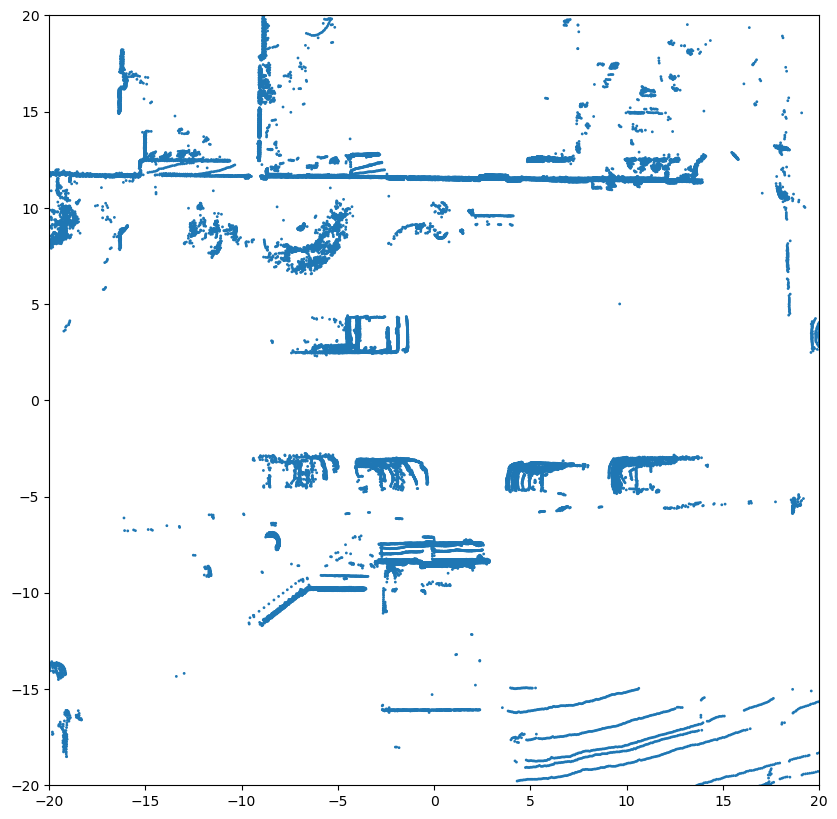

(96926, 3)


In [24]:
pc_vis(pc0_ego[~vis_data['gm']], size=1, range=(-20, 20))
print(pc0_ego.shape)

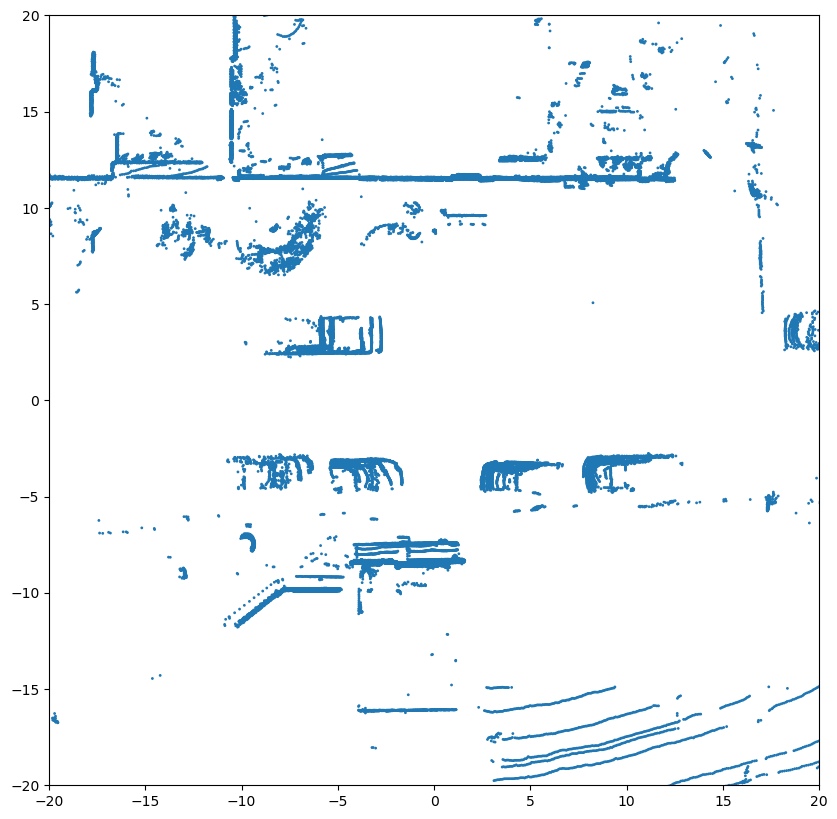

In [25]:
pc_vis(pc0_sensor[~vis_data['gm']], size=1, range=(-20, 20))

### Get the point within a bouding box 
Please note, the input point clouds of sceneflow is defined in the **sensor** coordinate, but the raw point cloud data and the bounding boxes are defined in the **ego** coordinate.

In [26]:
BOUNDING_BOX_EXPANSION: Final = 0.2
bboxes = dict()
for id in cuboids:
    bbox = dict()
    c0 = cuboids[id]
    # print('c0:', c0)
    c0.length_m += BOUNDING_BOX_EXPANSION
    c0.width_m += BOUNDING_BOX_EXPANSION
    obj_pts, obj_mask = c0.compute_interior_points(pc0_ego)
    
    bbox['cuboid'] = c0
    bbox['obj_pts'] = obj_pts
    bbox['obj_mask'] = obj_mask
    bboxes[id] = bbox
    
    # print('pc0 shape:', pc0_ego.shape)
    # print('obj_pts shape:', obj_pts.shape, obj_pts)
    # print('obj_mask shape:', obj_mask.shape)

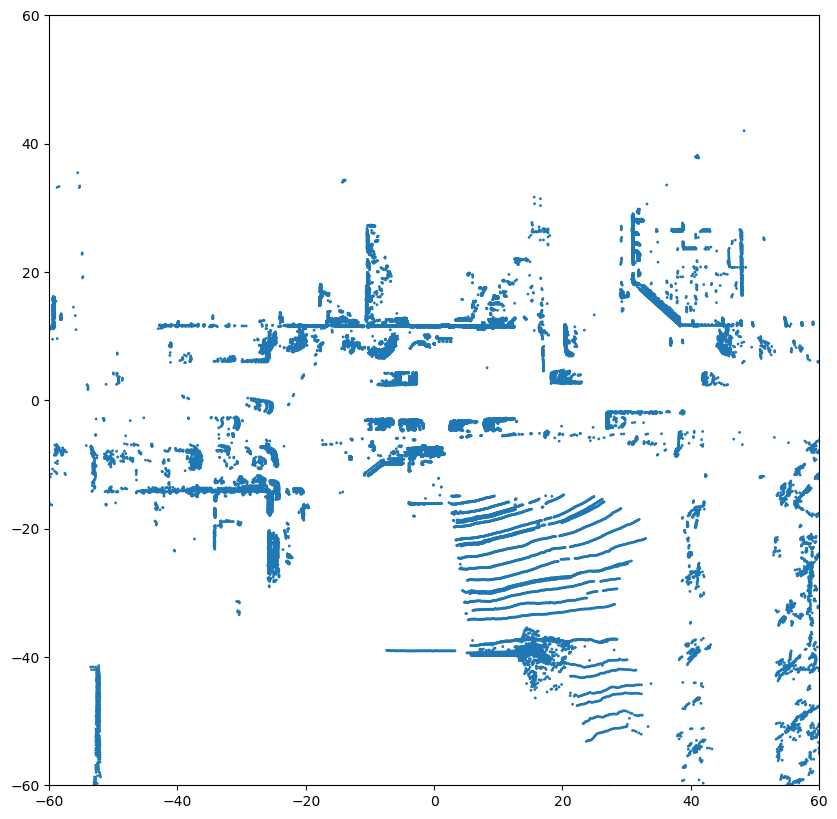

In [27]:
pc_vis(pc0_sensor[~vis_data['gm']], size=1, range=(-60, 60))

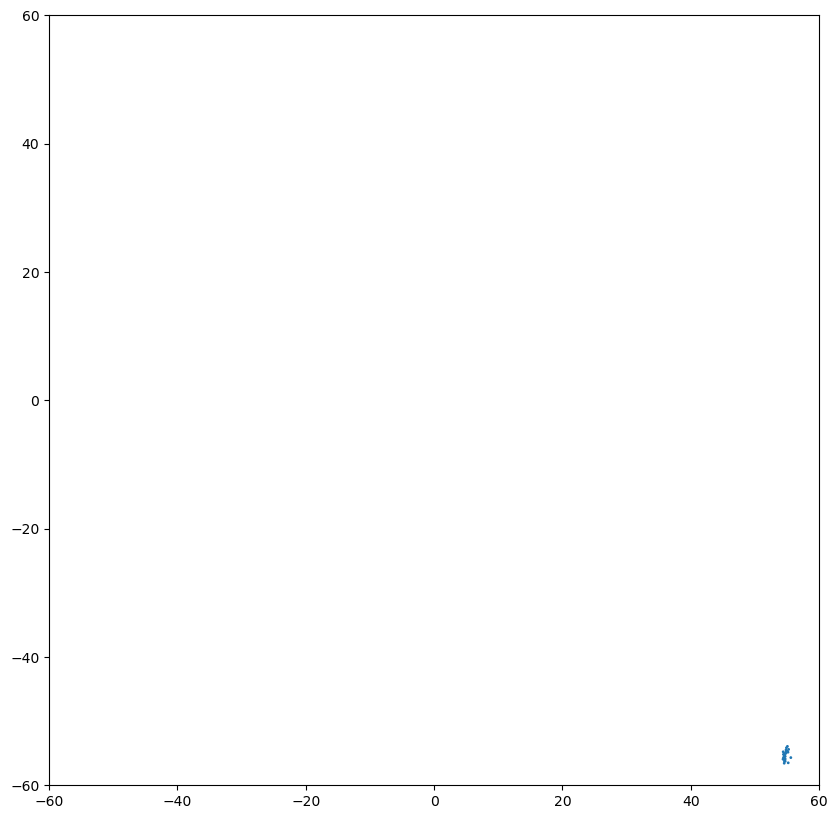

In [28]:
pc_vis(obj_pts, size=1, range=(-60, 60))

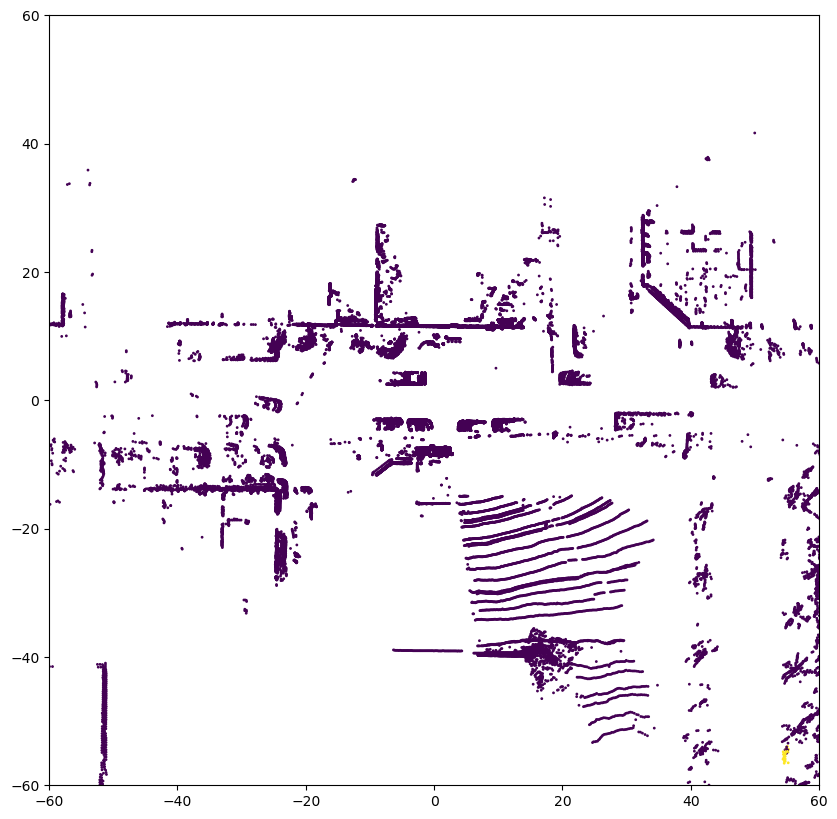

In [29]:
pc_vis(pc0_ego[~vis_data['gm']], c= obj_mask[~vis_data['gm']],size=1, range=(-60, 60))

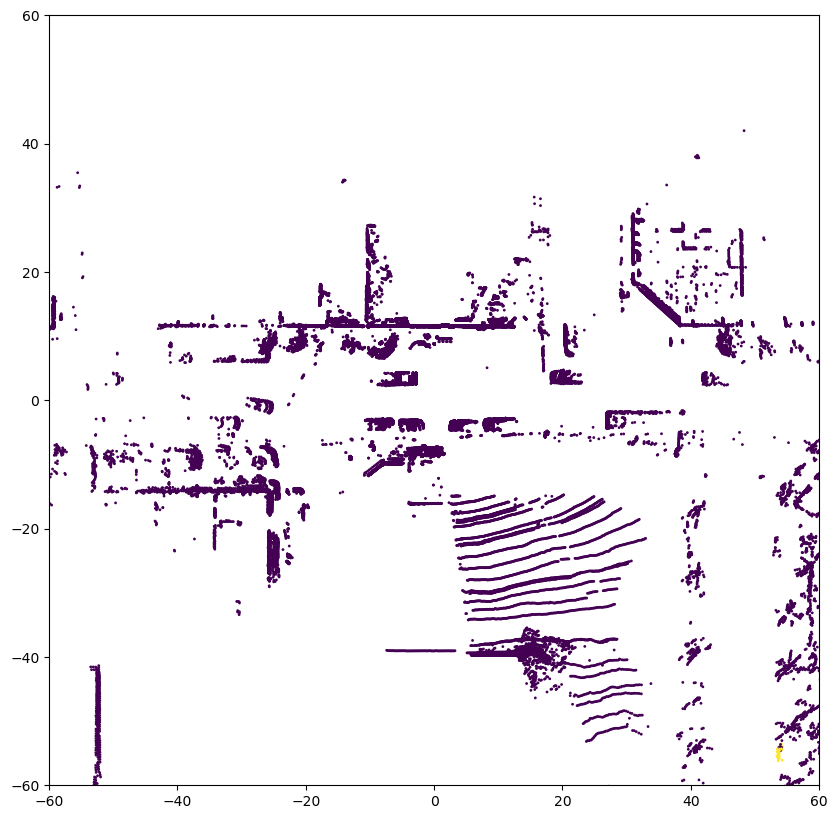

In [30]:
pc_vis(pc0_sensor[~vis_data['gm']], c= obj_mask[~vis_data['gm']],size=1, range=(-60, 60))

In [31]:
print(len(bboxes))
print(len(cuboids))

id_idx = 45
id = list(cuboids.keys())[id_idx]
bbox_info = bboxes[id]

63
63


In [32]:
bbox = bbox_info['cuboid']
obj_pts = bbox_info['obj_pts']
obj_mask = bbox_info['obj_mask']
print('bbox:', bbox)
print('obj_pts:', obj_pts.shape, obj_pts)
print('obj_mask:', obj_mask.shape)  

bbox: Cuboid(dst_SE3_object=SE3(rotation=array([[ 0.99976244,  0.0217959 ,  0.        ],
       [-0.0217959 ,  0.99976244, -0.        ],
       [-0.        ,  0.        ,  1.        ]]), translation=array([68.59127407, -4.13174815,  0.26737631])), length_m=4.23, width_m=2.0027507066726686, height_m=1.57659912109375, timestamp_ns=315974393359879000, category='REGULAR_VEHICLE')
obj_pts: (11, 3) [[ 6.67500000e+01 -3.22070312e+00 -2.56591797e-01]
 [ 6.65625000e+01 -3.79882812e+00  1.28051758e-01]
 [ 6.71250000e+01 -3.23046875e+00  4.97070312e-01]
 [ 6.68125000e+01 -3.44335938e+00  5.02441406e-01]
 [ 6.97500000e+01 -3.31445312e+00 -4.59228516e-01]
 [ 6.70625000e+01 -3.41210938e+00 -3.80126953e-01]
 [ 6.66875000e+01 -3.35156250e+00  9.73510742e-03]
 [ 6.69375000e+01 -3.38281250e+00  3.82568359e-01]
 [ 6.66875000e+01 -3.59765625e+00  3.85742188e-01]
 [ 6.66250000e+01 -3.79687500e+00  3.86962891e-01]
 [ 6.73125000e+01 -3.81835938e+00  7.55859375e-01]]
obj_mask: (96926,)


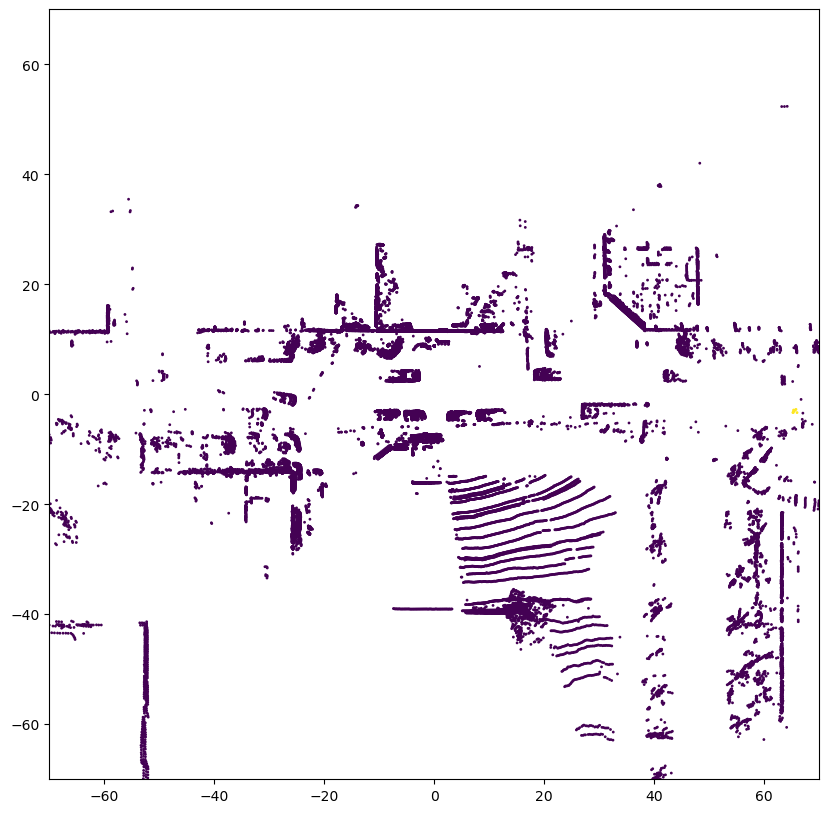

In [33]:
pc_vis(pc0_sensor[~vis_data['gm']], c= obj_mask[~vis_data['gm']],size=1, range=(-70, 70))

#### Get corners/vertices of a cuboid

     Return the cuboid vertices in the destination reference frame.

            5------4
            |\\    |\\
            | \\   | \\
            6--\\--7  \\
            \\  \\  \\ \\
        l    \\  1-------0    h
         e    \\ ||   \\ ||   e
          n    \\||    \\||   i
           g    \\2------3    g
            t      width.     h
             h.               t.

        Returns:
            (8,3) array of cuboid vertices.
        

In [34]:
vertices = bbox.vertices_m
print('vertices:', vertices.shape, vertices)    

vertices: (8, 3) [[70.72759751 -3.17670901  1.05567587]
 [70.68394576 -5.17898394  1.05567587]
 [70.68394576 -5.17898394 -0.52092325]
 [70.72759751 -3.17670901 -0.52092325]
 [66.49860238 -3.08451236  1.05567587]
 [66.45495063 -5.0867873   1.05567587]
 [66.45495063 -5.0867873  -0.52092325]
 [66.49860238 -3.08451236 -0.52092325]]


In [35]:
bev_corners = vertices[[2,3,7,6],:]
print('bev_corners:', bev_corners, bev_corners.shape)

bev_corners: [[70.68394576 -5.17898394 -0.52092325]
 [70.72759751 -3.17670901 -0.52092325]
 [66.49860238 -3.08451236 -0.52092325]
 [66.45495063 -5.0867873  -0.52092325]] (4, 3)


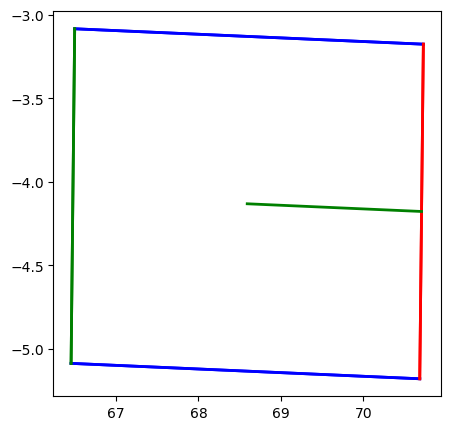

In [36]:
### Draw in a plot
fig, ax = plt.subplots(figsize=(5, 5))
linewidth = 2

def draw_rect(selected_corners, color):
    prev = selected_corners[-1]
    for corner in selected_corners:
        ax.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
        prev = corner
        
corners_2d = vertices[:, :2]

## draw the sides
for i in np.arange(4):
    ax.plot([corners_2d[i][0], corners_2d[i + 4][0]],
            [corners_2d[i][1], corners_2d[i + 4][1]],
                color='b', linewidth=linewidth)

# draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
draw_rect(corners_2d[:4], 'r')
draw_rect(corners_2d[4:], 'g')

# draw line indicating the front
center_bottom_forward = np.mean(corners_2d[2:4], axis=0)
center_bottom = np.mean(corners_2d[[2, 3, 7, 6]], axis=0)
ax.plot([center_bottom[0], center_bottom_forward[0]],
            [center_bottom[1], center_bottom_forward[1]],
            color='g', linewidth=linewidth)


 

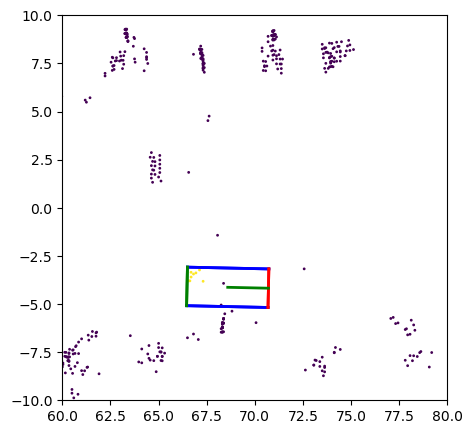

In [37]:
pc = pc0_ego[~vis_data['gm']]
c = obj_mask[~vis_data['gm']]
size = 1
pc_range = (-70, 70)
linewidth = 2

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(pc[:,0], 
        pc[:,1],
        c = c,
        sizes=np.ones_like(pc[:,0])*size,)

def draw_rect(selected_corners, color):
    prev = selected_corners[-1]
    for corner in selected_corners:
        ax.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
        prev = corner
        
corners_2d = vertices[:, :2]

## draw the sides
for i in np.arange(4):
    ax.plot([corners_2d[i][0], corners_2d[i + 4][0]],
            [corners_2d[i][1], corners_2d[i + 4][1]],
                color='b', linewidth=linewidth)

# draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
draw_rect(corners_2d[:4], 'r')
draw_rect(corners_2d[4:], 'g')

# draw line indicating the front
center_bottom_forward = np.mean(corners_2d[2:4], axis=0)
center_bottom = np.mean(corners_2d[[2, 3, 7, 6]], axis=0)
ax.plot([center_bottom[0], center_bottom_forward[0]],
            [center_bottom[1], center_bottom_forward[1]],
            color='g', linewidth=linewidth)



ax.set_xlim(60, 80)
ax.set_ylim(-10,10)   
ax.set_alpha(0.5) 
ax.set_aspect('equal')
plt.show()

### transfer bound box to the sensor coordinate

In [38]:
print(vertices.shape)
vertices_sensor = sweep.ego_SE3_up_lidar.inverse().transform_point_cloud(vertices)
print(vertices_sensor.shape)

(8, 3)
(8, 3)


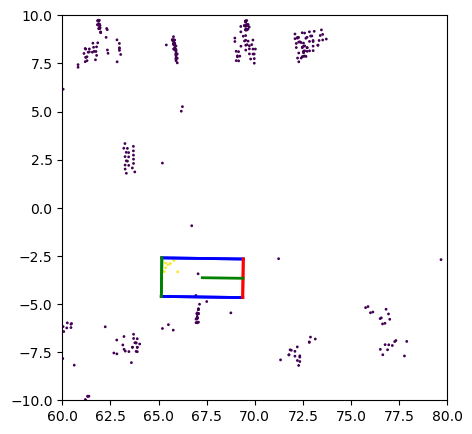

In [39]:
pc = pc0_sensor[~vis_data['gm']]
c = obj_mask[~vis_data['gm']]
size = 1
pc_range = (-70, 70)
linewidth = 2

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(pc[:,0], 
        pc[:,1],
        c = c,
        sizes=np.ones_like(pc[:,0])*size,)

def draw_rect(selected_corners, color):
    prev = selected_corners[-1]
    for corner in selected_corners:
        ax.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
        prev = corner
        
corners_2d = vertices_sensor[:, :2]

## draw the sides
for i in np.arange(4):
    ax.plot([corners_2d[i][0], corners_2d[i + 4][0]],
            [corners_2d[i][1], corners_2d[i + 4][1]],
                color='b', linewidth=linewidth)

# draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
draw_rect(corners_2d[:4], 'r')
draw_rect(corners_2d[4:], 'g')

# draw line indicating the front
center_bottom_forward = np.mean(corners_2d[2:4], axis=0)
center_bottom = np.mean(corners_2d[[2, 3, 7, 6]], axis=0)
ax.plot([center_bottom[0], center_bottom_forward[0]],
            [center_bottom[1], center_bottom_forward[1]],
            color='g', linewidth=linewidth)



ax.set_xlim(60, 80)
ax.set_ylim(-10,10)   
ax.set_alpha(0.5) 
ax.set_aspect('equal')
plt.show()

## Visualize all the bounding boxes

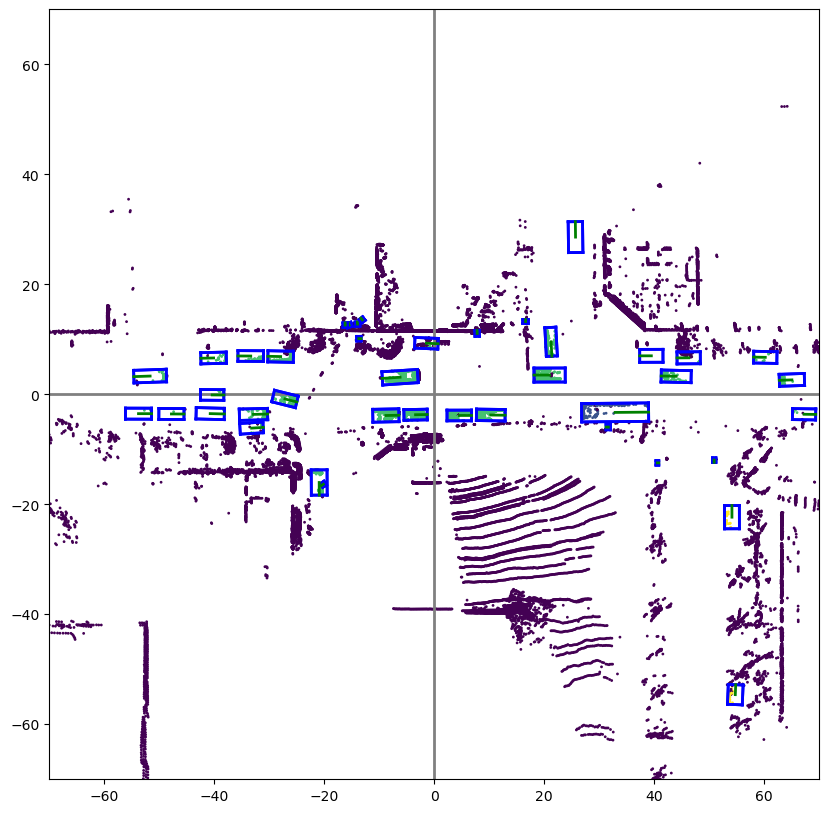

In [40]:
### lidar frame
pc = pc0_sensor[~vis_data['gm']]
c = gt_label
size = 1
pc_range = (-70, 70)

linewidth = 2

fig, ax = plt.subplots(figsize=(10, 10))

ax.vlines(0, -70, 70, color='grey', linewidth=linewidth)
ax.hlines(0, -70, 70, color='grey', linewidth=linewidth)

ax.scatter(pc[:,0], 
        pc[:,1],
        c = c,
        sizes=np.ones_like(pc[:,0])*size,)

def draw_rect(selected_corners, color):
    prev = selected_corners[-1]
    for corner in selected_corners:
        ax.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
        prev = corner
for id in cuboids:
    c0 = cuboids[id]
    vertices = c0.vertices_m
    vertices_sensor = sweep.ego_SE3_up_lidar.inverse().transform_point_cloud(vertices)
    
    corners_2d = vertices_sensor[:, :2]

    ## draw the sides
    for i in np.arange(4):
        ax.plot([corners_2d[i][0], corners_2d[i + 4][0]],
                [corners_2d[i][1], corners_2d[i + 4][1]],
                    color='b', linewidth=linewidth)

    # draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners_2d[:4], 'b')
    draw_rect(corners_2d[4:], 'b')

    # draw line indicating the front
    center_bottom_forward = np.mean(corners_2d[2:4], axis=0)
    center_bottom = np.mean(corners_2d[[2, 3, 7, 6]], axis=0)
    ax.plot([center_bottom[0], center_bottom_forward[0]],
                [center_bottom[1], center_bottom_forward[1]],
                color='g', linewidth=linewidth)




ax.set_xlim(*pc_range)
ax.set_ylim(*pc_range)   
ax.set_alpha(0.5) 
ax.set_aspect('equal')
plt.show()

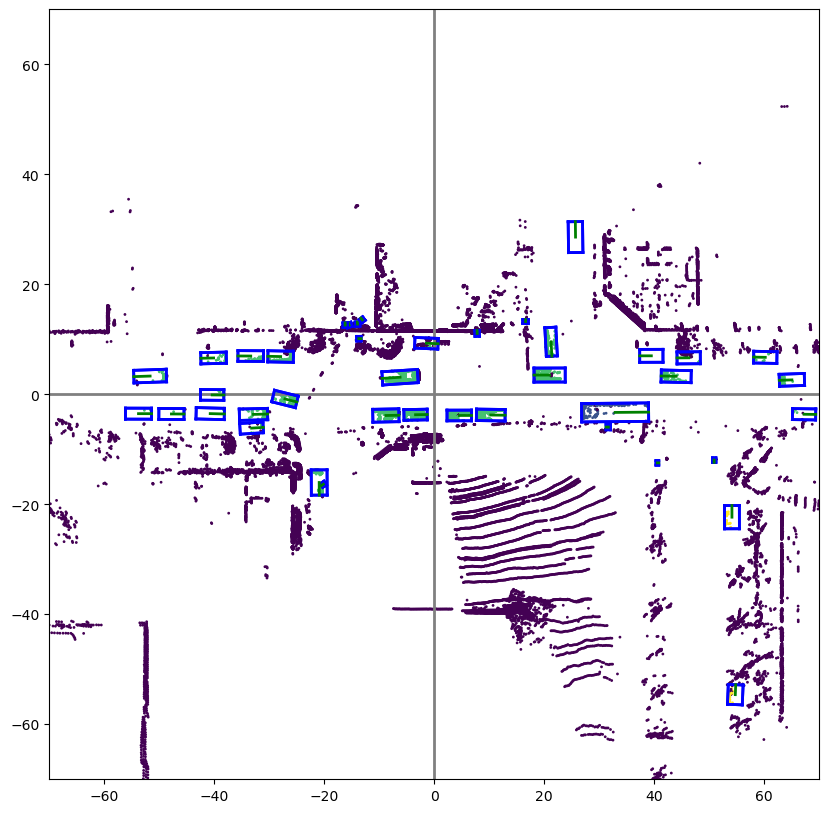

In [41]:
### lidar frame
pc = pc0_sensor[~vis_data['gm']]
c = gt_label
size = 1
pc_range = (-70, 70)

linewidth = 2

fig, ax = plt.subplots(figsize=(10, 10))

ax.vlines(0, -70, 70, color='grey', linewidth=linewidth)
ax.hlines(0, -70, 70, color='grey', linewidth=linewidth)

ax.scatter(pc[:,0], 
        pc[:,1],
        c = c,
        sizes=np.ones_like(pc[:,0])*size,)

def draw_rect(selected_corners, color):
    prev = selected_corners[-1]
    for corner in selected_corners:
        ax.plot([prev[0], corner[0]], [prev[1], corner[1]], color=color, linewidth=linewidth)
        prev = corner
for id in cuboids:
    c0 = cuboids[id]
    vertices = c0.vertices_m
    vertices_sensor = sweep.ego_SE3_up_lidar.inverse().transform_point_cloud(vertices)
    
    corners_2d = vertices_sensor[:, :2]

    ## draw the sides
    for i in np.arange(4):
        ax.plot([corners_2d[i][0], corners_2d[i + 4][0]],
                [corners_2d[i][1], corners_2d[i + 4][1]],
                    color='b', linewidth=linewidth)

    # draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners_2d[:4], 'b')
    draw_rect(corners_2d[4:], 'b')

    # draw line indicating the front
    center_bottom_forward = np.mean(corners_2d[2:4], axis=0)
    center_bottom = np.mean(corners_2d[[2, 3, 7, 6]], axis=0)
    ax.plot([center_bottom[0], center_bottom_forward[0]],
                [center_bottom[1], center_bottom_forward[1]],
                color='g', linewidth=linewidth)




ax.set_xlim(*pc_range)
ax.set_ylim(*pc_range)   
ax.set_alpha(0.5) 
ax.set_aspect('equal')
plt.show()

### script for eval for different object length

In [2]:
import torch
import numpy as np

In [42]:
length = cuboid.length_m
print(length)

3.41459


In [4]:
# length_tensor = torch.tensor(length)
boundaries = torch.tensor([1, 2.5, 4.5, 6, 9, 12])
SIZE_CLASSES = ['T', 'XS', 'S', 'M', 'L', 'XL', 'U']

# 0 'T':  (0.0 - 1.0] m Pedestrians
# 1 'XS': (1.0 - 2.5] m Bicycles/e‐bikes, Standing scooters, wheelchairs, etc.
# 2 'S':  (2.5 - 4.5] m Motorcycles (with riders), Small cars (hatchbacks, subcompacts, city cars)
# 3 'M':  (4.5 - 6.0] m Sedans, SUVs, pickup trucks, Minivans
# 4 'L':  (6.0 - 9.0] m: Small box trucks, Large vans (delivery vans, small shuttle vans)
# 5 'XL': (9.0 - 12.0] m: Standard city buses, Medium trucks (e.g., straight trucks, mid‐size box trucks)
# 6 'U':  (> 12.0 m: Tractor‐trailers (semi‐trucks), Articulated/tandem buses (if present)

In [11]:
length = 1
boundaries = torch.tensor([1, 2.5, 4.5, 6, 9, 12])
SIZE_CLASSES = ['T', 'XS', 'S', 'M', 'L', 'XL', 'U']
class_idx = torch.bucketize(length, boundaries)
size_class = SIZE_CLASSES[class_idx] 
print(size_class)

T


In [13]:
## numpy bucketize

bins = boundaries.numpy()
class_idx = np.digitize(length, bins, right=True)
size_class = SIZE_CLASSES[class_idx]
print(size_class)



T


### Try strcutrue

In [23]:
a = defaultdict(dict(
    Static=[],
    Dynamic=[],
))
print(a)

TypeError: first argument must be callable or None

In [59]:
a = 'data/Argoverse2_demo/preprocess_v2/sensor/val'

b = a.split('/')[:2]
print(b)

c = osp.join(b[0], b[1])
print(c)


['data', 'Argoverse2_demo']
data/Argoverse2_demo
